**Aplicação de técnicas de classificação de texto na arquitetura de Chatbots hierárquicos**

**Mestrado Profissional em Computação Aplicada - PPCA - Universidade de Brasília**

**Disciplina**: Mineração de Dados

**Orientador**: Prof. Dr. Marcelo Ladeira <mladeira@unb.br>

**Alunos**: 
 - José Ronaldo Agra De Souza Filho <jose.agra@aluno.unb.br>
 - Bruno Gomes Resende <bruno.resende@aluno.unb.br>
 - Célio Castro Wermelinger <celio.wermelinger@aluno.unb.br> 

**Palavras-Chave:**

Chatbot; Text Classification; Machine Learning; Text Mining; NLP;

In [ ]:
# Install packages
# Note: use Python 3.8 env
#!pip install --pre pycaret

## Importação das bibliotecas necessárias a este notebook.

In [107]:
# Import packages
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from pycaret.classification import *

# download das stopwords para o idioma português
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ronal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Montagem dos datasets a serem utilizados no experimento

Cada categoria possui um arquivo contendo o texto que serve se exemplo de treinamento e a categoria de cada um desses textos.

Primeiro é montado um único dataset, contendo todos os exemplos das 3 classes, e as referidas categorias.

Após isso, este dataset é clonado 3 vezes, sendo um para cada classe. Nestes novos datasets, a categorizaçõ passa a ser binária. Ou seja, em vez de ter a informação das 3 classes, ele tem a informação se os exemplos de treinamento são ou não de uma referida classe.

Assim, cria-se os seguintes datasets:
* df_treino_covid: contém todos os exemplos de treinamento. Para os que representam a classe "covid", a coluna "category" é configurada com 1, caso contrário com 0.
* df_treino_seloturismo: contém todos os exemplos de treinamento. Para os que representam a classe "seloturismo", a coluna "category" é configurada com 1, caso contrário com 0.
* df_treino_tuberculose: contém todos os exemplos de treinamento. Para os que representam a classe "tuberculose", a coluna "category" é configurada com 1, caso contrário com 0.

In [122]:
# Montagem do dataset
df_covid = pd.read_csv('data/exemplos-treinamento-covid.csv', delimiter=';')
df_seloturismo = pd.read_csv('data/exemplos-treinamento-seloturismo.csv', delimiter=';')
df_tuberculose = pd.read_csv('data/exemplos-treinamento-tuberculose.csv', delimiter=';')
df_all = pd.concat([df_covid, df_seloturismo, df_tuberculose], axis=0)

# cria o dataframe de treino para a categoria covid
df_treino_covid = df_all.copy()
df_treino_covid.reset_index(drop=True, inplace=True)
df_treino_covid['category'] = df_all.reset_index().category.map({'covid':1, 'seloturismo':0, 'tuberculose':0})

## Representação dos textos em vetores

Realiza a representação de texto, fazendo uso do TF-IDF e realizando algumas tarefas de tratamento dos dados.

Ao realizar a vetorização dos textos, são removidas as stopwords e também os acentos das palavras.

Deciciu-se por não realizar as tarefas de "lemmatization" nem de "stemming", porque no caso deste experimento a simplificação de palavras em radicais poderia prejudicar o desempenho na identificação das classes.

In [123]:
# recupera as stopwords do idioma português
stop_words = stopwords.words('portuguese')

# vetorização das palavras
tv = TfidfVectorizer(lowercase=True, stop_words=stop_words, strip_accents='unicode', token_pattern="[A-Za-z]+")

tf_idf_covid = tv.fit_transform(df_treino_covid['input'])

# vetorização para o dataframe referente à categoria COVID
df_covid_vetorizado = pd.DataFrame(tf_idf_covid.toarray(), columns=tv.get_feature_names())
df_covid_vetorizado['target_cat'] = df_treino_covid.reset_index().category

## Criação dos classificadores binários

São criados 3 classificadores binários, cada um especializado em identificar uma das categorias existentes: covid, selo turismo e tuberculose.

Para cada classificador, a configuração utilizada será:
* Dados a classificar (data): dados relacionados à categoria COVID;
* Coluna que representa a classe (target): a coluna 'target_cat' que informa se o texto é da classe covid (1) ou não (0).
* Semente para possibilitar a reprodutibilidade (session_id): 20221
* Proporção do dataset que será usado para treinamento e validação (train_size): 70%
* Quantidade de dobras (folds) que será utilizada na validação cruzada (fold): 10 (por padrão a estratégia utilizada é a 'stratified kfold').
* Controle da entrada de confirmação de tipos de dados quando o setup é executado (silent): True (devido ao modo de execução automatizado).

## Classificador binário para a classe COVID

In [124]:
config_covid = setup(data=df_covid_vetorizado, target='target_cat',
                     session_id=20221, train_size = 0.7, fold=10, silent=True)

,Description,Value
0,session_id,20221
1,Target,target_cat
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1042, 1047)"
5,Missing Values,False
6,Numeric Features,622
7,Categorical Features,424
8,Ordinal Features,False
9,High Cardinality Features,False


## Comparação entre os modelos disponíveis na biblioteca

Essa função treina todos os modelos disponíveis da biblioteca, e os pontua usando validação cruzada configurada no setup estratificada para avaliação de métricas.

A saída imprime uma grade de pontuação que mostra as métricas: acurácia média, AUC, recall, precisão e F1 de todos os modelos disponíveis na biblioteca de modelos.


In [125]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9767,0.9917,0.8485,1.0000,0.9150,0.9017,0.9077,0.0840
ada,Ada Boost Classifier,0.9767,0.9861,0.8659,0.9846,0.9188,0.9053,0.9096,0.0720
dt,Decision Tree Classifier,0.9739,0.9301,0.8667,0.9652,0.9107,0.8955,0.8990,0.0240
et,Extra Trees Classifier,0.9739,0.9916,0.8576,0.9757,0.9087,0.8937,0.8989,0.1090
gbc,Gradient Boosting Classifier,0.9684,0.9790,0.8136,0.9833,0.8883,0.8701,0.8768,0.1490
svm,SVM - Linear Kernel,0.9644,0.0000,0.8023,0.8756,0.8344,0.8232,0.8263,0.0210
ridge,Ridge Classifier,0.9630,0.0000,0.7697,0.9900,0.8625,0.8417,0.8527,0.0240
lightgbm,Light Gradient Boosting Machine,0.9520,0.9711,0.7061,0.9775,0.8115,0.7856,0.8038,0.0360
lda,Linear Discriminant Analysis,0.9464,0.9369,0.7621,0.8874,0.8103,0.7800,0.7888,0.1340
nb,Naive Bayes,0.9383,0.8843,0.8061,0.8071,0.8027,0.7662,0.7688,0.0200


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=20221,
                       verbose=0, warm_start=False)

## Criando os modelos melhor pontuados na compare_models

In [114]:
# cria o modelo
random_forest = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9863,1.0000,0.9091,1.0000,0.9524,0.9444,0.9459
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9726,1.0000,0.8182,1.0000,0.9000,0.8843,0.8903
3,0.9589,0.9912,0.7273,1.0000,0.8421,0.8192,0.8329
4,0.9726,0.9883,0.8182,1.0000,0.9000,0.8843,0.8903
5,0.9726,1.0000,0.8182,1.0000,0.9000,0.8843,0.8903
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9863,1.0000,0.9167,1.0000,0.9565,0.9484,0.9497
8,0.9589,0.9959,0.7500,1.0000,0.8571,0.8337,0.8455


In [115]:
# realiza o ensemble dos modelos e seleciona o melhor
melhor_modelo_bagging = ensemble_model(random_forest, choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9726,1.0000,0.8182,1.0000,0.9000,0.8843,0.8903
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9726,1.0000,0.8182,1.0000,0.9000,0.8843,0.8903
3,0.9452,0.9831,0.6364,1.0000,0.7778,0.7483,0.7732
4,0.9589,0.9861,0.7273,1.0000,0.8421,0.8192,0.8329
5,0.9726,1.0000,0.8182,1.0000,0.9000,0.8843,0.8903
6,0.9863,1.0000,0.9167,1.0000,0.9565,0.9484,0.9497
7,0.9726,1.0000,0.8333,1.0000,0.9091,0.8931,0.8983
8,0.9589,0.9932,0.7500,1.0000,0.8571,0.8337,0.8455


In [116]:
# Imprimindo melhor modelo
print(melhor_modelo_bagging)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=20221,
                       verbose=0, warm_start=False)


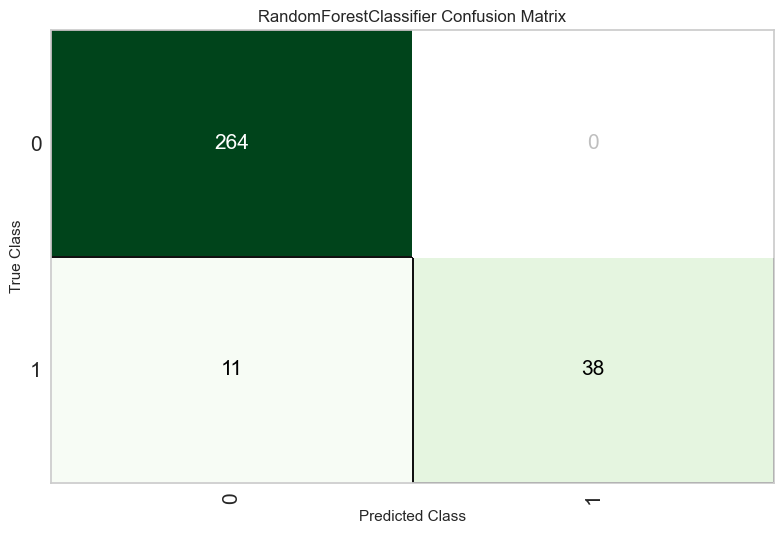

In [117]:
plot_model(melhor_modelo_bagging, plot = 'confusion_matrix')

## Predição do modelo treinado

Antes de finalizar o modelo, realiza-se uma verificação final prevendo o conjunto de teste/hold-out e revisando as métricas de avaliação. Esta verificação é realizada com os 30% dos dados separados para isto no início deste notebook.

Perceba abaixo que não houve grande variação entre os resultados do teste/hold-out e do treinamento, inclusive as métricas do teste se apresentam melhores, isso indica que não ocorreu o overfitting.

In [118]:
predict_model(melhor_modelo_bagging)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9649,0.9974,0.7755,1.0000,0.8736,0.8535,0.8628


,abracar,acesso,acho,acompanhamento,acontece,acontecera,acordo,acrescido,aderi,aderir,...,vantagens_0.8863410949707031,vantajoso_0.8135361075401306,vao_0.0,vem_0.6479084491729736,vindo_0.5517596006393433,vir_0.42635244131088257,vistorias_0.712486743927002,target_cat,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.99
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0.67
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1.00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1.00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.89
309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1.00
310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.99
311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1.00


## Finalização do modelo

A finalização do modelo é a última etapa do experimento. A função finalize_model() ajusta o modelo ao conjunto de dados completo, incluindo a amostra de teste/hold-out (30% neste caso). O objetivo dessa função é treinar o modelo no conjunto de dados completo antes de ser implantado na produção.

In [119]:
modelo_final = finalize_model(melhor_modelo_bagging)
predict_model(modelo_final)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,abracar,acesso,acho,acompanhamento,acontece,acontecera,acordo,acrescido,aderi,aderir,...,vantagens_0.8863410949707031,vantajoso_0.8135361075401306,vao_0.0,vem_0.6479084491729736,vindo_0.5517596006393433,vir_0.42635244131088257,vistorias_0.712486743927002,target_cat,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.98
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.80
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1.00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1.00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.96
309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1.00
310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1.00
311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1.00


## Salvando o modelo final

Agora terminamos o experimento finalizando o modelo que agora está armazenado na variável 'modelo_final'.

Nosso modelo final pode ser descrito como:

Também usamos o modelo armazenado em final_rf para prever data_unseen. Isso nos leva ao final de nosso experimento, mas uma pergunta ainda deve ser feita: o que acontece quando você tem mais dados novos para prever? Você tem que passar por todo o experimento novamente? A resposta é não, a função embutida do PyCaret save_model() permite que você salve o modelo junto com todo o pipeline de transformação para uso posterior.

In [121]:
save_model(modelo_final,'models/20220911-modelo-final-covid-random-forest')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='target_cat', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='auto',
                                         max_l